# Classification d'image

https://github.com/pytorch/examples/blob/master/mnist/main.py

http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf

https://www.superdatascience.com/blogs/the-ultimate-guide-to-convolutional-neural-networks-cnn

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## étape 1 : définition des image train et eval

In [2]:
torch.manual_seed(1)
use_cuda = torch.cuda.is_available()


train_batch_size = 64
test_batch_size = 1000
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}


# random_split
dataset = datasets.MNIST('images', train=True, download=True, transform=transform)

nb_train = int(0.8*len(dataset))
nb_test  = len(dataset)-nb_train
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [nb_train, nb_test])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size,  shuffle=True, **kwargs)


print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))

The train set contains 48000 images, in 750 batches
The test set contains 12000 images, in 12 batches


## étape 2 : Réseau

le réseau LeNet comprend deux principales étapes :
- l'extraction des caractéristique de l'image
- la classification de cette image en fonction de ses caractéristiques

<img src="https://miro.medium.com/max/3712/1*7K4ZTTfZb-hbjoADbisHAg.png" width="600"/>

### extraction des caractéristique de l'image

pour extraire ses caractéristiques l'image vas subire une série de modification : 

- une convolution (voir [Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d))
     - une convolution est une fonction dérivée de deux fonctions données par intégration qui exprime comment la forme de l'une est modifiée par l'autre
     - l'image est convoluer par des détecteurs de caractéristiques (appelé kernel)
<img src="https://sds-platform-private.s3-us-east-2.amazonaws.com/uploads/35_blog_image_11.png" width="600"/>

- une fonction d'Unité de Rectification Linéaire (voir [ReLu()](https://pytorch.org/docs/stable/nn.html#relu))
    - pour ne garder que les valeurs positives dans les carte de caratéristiques engendré par la convolution
    - ReLU(x)=max(0,x) <img src="https://pytorch.org/docs/stable/_images/ReLU.png" width="400"/>



- un Max Pooling (voir [MaxPool2d](https://pytorch.org/docs/stable/nn.html#maxpool2d))
    - pour ne garder que les valeurs maximales dans une zone
    - réduit les carte de caractéristique et évite un surapprentissage
<img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png" width="300"/>

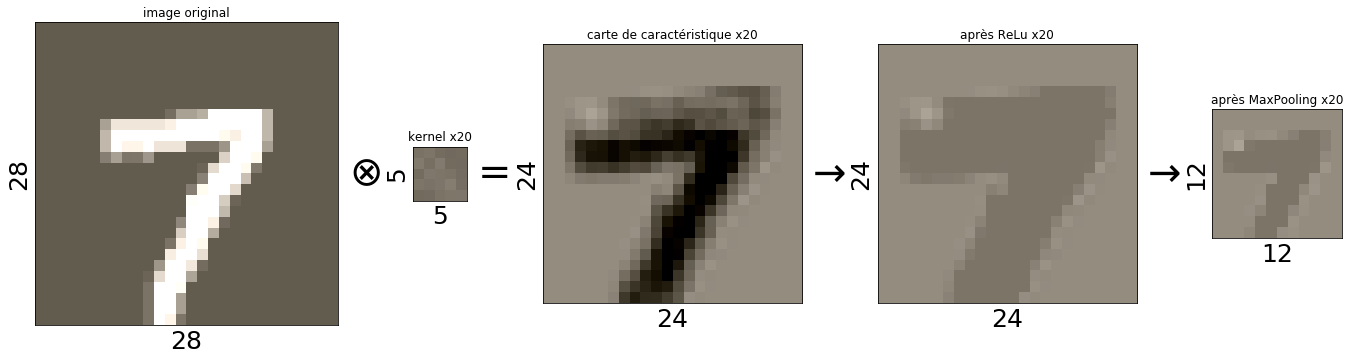

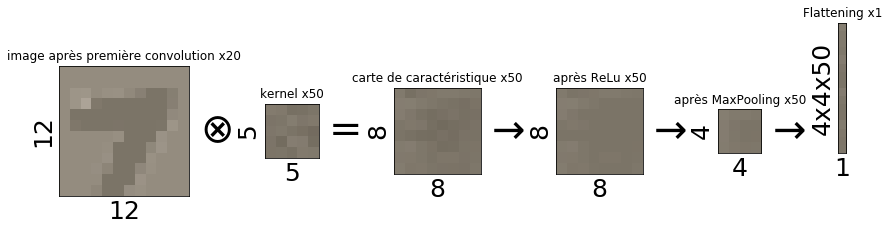

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from convolution import img_conv

a = dict(iter(train_loader))
inputs = list(a.keys())
#classe = a[inputs[0]]

fig = plt.figure(figsize=(15,15))
conv1 = nn.Conv2d(1, 20, 5, 1)
i = img_conv(fig, inputs[13][13], conv1, ['image original', 'kernel x20',
                                          'carte de caractéristique x20',
                                          'après ReLu x20', 'après MaxPooling x20'])

fig = plt.figure(figsize=(15,15))
conv2 = nn.Conv2d(1, 50, 5, 1)
i = img_conv(fig, i, conv2, ['image après première convolution x20', 'kernel x50',
                             'carte de caractéristique x50',
                             'après ReLu x50', 'après MaxPooling x50'], conv2=True)

### Classification

- fully connected

- Linear (voir [Linear](https://pytorch.org/docs/stable/nn.html#linear))
    - Applique une transformation linéaire aux données entrantes
    
- log_softmax (voir [log_softmax](https://pytorch.org/docs/stable/nn.functional.html#log-softmax))

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        # Extraction de caractéristiques 1
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        # Extraction de caractéristiques 2
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        
        # Classification
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## étape 3 : Entrainement du Réseau

In [5]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target) # The negative log likelihood loss.
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

- définition fonction loss + trouver la bonne ! [wiki](https://fr.wikipedia.org/wiki/R%C3%A9seau_neuronal_convolutif)

    La couche de perte spécifie comment l'entrainement du réseau pénalise l'écart entre le signal prévu et réel. Elle est normalement la dernière couche dans le réseau.

    Diverses fonctions de perte adaptées à différentes tâches peuvent y être utilisées [loss-functions](https://pytorch.org/docs/stable/nn.functional.html#loss-functions) :
    - La perte « Softmax »est utilisée pour prédire une seule classe parmi K classes mutuellement exclusives.
    - La perte par entropie croisée sigmoïde est utilisée pour prédire K valeurs de probabilité indépendante dans [0,1].
    - La perte euclidienne est utilisée pour régresser vers des valeurs réelles dans [-inf ,inf].

The negative log likelihood loss -> permet de maximiser l'erreur quand le bon label a une proba faible et de la diminuer quand bon label a proba élevé !

- backpropagation
    - l'erreur calculer se propage dans les première couche du réseau

<img src="https://d3i71xaburhd42.cloudfront.net/db39fd79bb591b04d33207992f6ccde03cabd861/7-Figure1-1.png" width="300"/>

## étape 3 : Test du Réseau

In [6]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct/len(test_loader.dataset)))
    return(100. * correct/len(test_loader.dataset))

In [7]:
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


epochs = 15
log_interval = 10

list_accuracy = []
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    accuracy = test(model, device, test_loader)
    list_accuracy.append(accuracy)

# save model
torch.save(model.state_dict(),"mnist_cnn.pt")

Train Epoch: 1 [0/48000 (0%)]	Loss: 2.304014
Train Epoch: 1 [640/48000 (1%)]	Loss: 2.261052
Train Epoch: 1 [1280/48000 (3%)]	Loss: 2.179912
Train Epoch: 1 [1920/48000 (4%)]	Loss: 2.037933
Train Epoch: 1 [2560/48000 (5%)]	Loss: 1.855935
Train Epoch: 1 [3200/48000 (7%)]	Loss: 1.656328
Train Epoch: 1 [3840/48000 (8%)]	Loss: 1.177441
Train Epoch: 1 [4480/48000 (9%)]	Loss: 0.781135
Train Epoch: 1 [5120/48000 (11%)]	Loss: 0.816078
Train Epoch: 1 [5760/48000 (12%)]	Loss: 0.587774
Train Epoch: 1 [6400/48000 (13%)]	Loss: 0.533632
Train Epoch: 1 [7040/48000 (15%)]	Loss: 0.561638
Train Epoch: 1 [7680/48000 (16%)]	Loss: 0.387017
Train Epoch: 1 [8320/48000 (17%)]	Loss: 0.387255
Train Epoch: 1 [8960/48000 (19%)]	Loss: 0.433788
Train Epoch: 1 [9600/48000 (20%)]	Loss: 0.420663
Train Epoch: 1 [10240/48000 (21%)]	Loss: 0.260771
Train Epoch: 1 [10880/48000 (23%)]	Loss: 0.372015
Train Epoch: 1 [11520/48000 (24%)]	Loss: 0.218204
Train Epoch: 1 [12160/48000 (25%)]	Loss: 0.354846
Train Epoch: 1 [12800/48000 

Train Epoch: 3 [8320/48000 (17%)]	Loss: 0.108957
Train Epoch: 3 [8960/48000 (19%)]	Loss: 0.075742
Train Epoch: 3 [9600/48000 (20%)]	Loss: 0.057880
Train Epoch: 3 [10240/48000 (21%)]	Loss: 0.046089
Train Epoch: 3 [10880/48000 (23%)]	Loss: 0.018145
Train Epoch: 3 [11520/48000 (24%)]	Loss: 0.018372
Train Epoch: 3 [12160/48000 (25%)]	Loss: 0.111902
Train Epoch: 3 [12800/48000 (27%)]	Loss: 0.007248
Train Epoch: 3 [13440/48000 (28%)]	Loss: 0.023944
Train Epoch: 3 [14080/48000 (29%)]	Loss: 0.037240
Train Epoch: 3 [14720/48000 (31%)]	Loss: 0.046323
Train Epoch: 3 [15360/48000 (32%)]	Loss: 0.053096
Train Epoch: 3 [16000/48000 (33%)]	Loss: 0.075846
Train Epoch: 3 [16640/48000 (35%)]	Loss: 0.032676
Train Epoch: 3 [17280/48000 (36%)]	Loss: 0.042303
Train Epoch: 3 [17920/48000 (37%)]	Loss: 0.085934
Train Epoch: 3 [18560/48000 (39%)]	Loss: 0.096029
Train Epoch: 3 [19200/48000 (40%)]	Loss: 0.156763
Train Epoch: 3 [19840/48000 (41%)]	Loss: 0.151341
Train Epoch: 3 [20480/48000 (43%)]	Loss: 0.066708
Tra

Train Epoch: 5 [16640/48000 (35%)]	Loss: 0.064998
Train Epoch: 5 [17280/48000 (36%)]	Loss: 0.035986
Train Epoch: 5 [17920/48000 (37%)]	Loss: 0.027144
Train Epoch: 5 [18560/48000 (39%)]	Loss: 0.066079
Train Epoch: 5 [19200/48000 (40%)]	Loss: 0.018411
Train Epoch: 5 [19840/48000 (41%)]	Loss: 0.003841
Train Epoch: 5 [20480/48000 (43%)]	Loss: 0.052422
Train Epoch: 5 [21120/48000 (44%)]	Loss: 0.045463
Train Epoch: 5 [21760/48000 (45%)]	Loss: 0.036887
Train Epoch: 5 [22400/48000 (47%)]	Loss: 0.149278
Train Epoch: 5 [23040/48000 (48%)]	Loss: 0.018786
Train Epoch: 5 [23680/48000 (49%)]	Loss: 0.060303
Train Epoch: 5 [24320/48000 (51%)]	Loss: 0.025632
Train Epoch: 5 [24960/48000 (52%)]	Loss: 0.006304
Train Epoch: 5 [25600/48000 (53%)]	Loss: 0.037616
Train Epoch: 5 [26240/48000 (55%)]	Loss: 0.195577
Train Epoch: 5 [26880/48000 (56%)]	Loss: 0.079650
Train Epoch: 5 [27520/48000 (57%)]	Loss: 0.015074
Train Epoch: 5 [28160/48000 (59%)]	Loss: 0.065154
Train Epoch: 5 [28800/48000 (60%)]	Loss: 0.029371


Train Epoch: 7 [25600/48000 (53%)]	Loss: 0.069795
Train Epoch: 7 [26240/48000 (55%)]	Loss: 0.017475
Train Epoch: 7 [26880/48000 (56%)]	Loss: 0.013094
Train Epoch: 7 [27520/48000 (57%)]	Loss: 0.015149
Train Epoch: 7 [28160/48000 (59%)]	Loss: 0.004753
Train Epoch: 7 [28800/48000 (60%)]	Loss: 0.029311
Train Epoch: 7 [29440/48000 (61%)]	Loss: 0.004301
Train Epoch: 7 [30080/48000 (63%)]	Loss: 0.014106
Train Epoch: 7 [30720/48000 (64%)]	Loss: 0.045391
Train Epoch: 7 [31360/48000 (65%)]	Loss: 0.005178
Train Epoch: 7 [32000/48000 (67%)]	Loss: 0.027822
Train Epoch: 7 [32640/48000 (68%)]	Loss: 0.003163
Train Epoch: 7 [33280/48000 (69%)]	Loss: 0.017489
Train Epoch: 7 [33920/48000 (71%)]	Loss: 0.010361
Train Epoch: 7 [34560/48000 (72%)]	Loss: 0.021447
Train Epoch: 7 [35200/48000 (73%)]	Loss: 0.008183
Train Epoch: 7 [35840/48000 (75%)]	Loss: 0.003781
Train Epoch: 7 [36480/48000 (76%)]	Loss: 0.010949
Train Epoch: 7 [37120/48000 (77%)]	Loss: 0.023008
Train Epoch: 7 [37760/48000 (79%)]	Loss: 0.007926


Train Epoch: 9 [33920/48000 (71%)]	Loss: 0.003212
Train Epoch: 9 [34560/48000 (72%)]	Loss: 0.010013
Train Epoch: 9 [35200/48000 (73%)]	Loss: 0.014634
Train Epoch: 9 [35840/48000 (75%)]	Loss: 0.009734
Train Epoch: 9 [36480/48000 (76%)]	Loss: 0.051978
Train Epoch: 9 [37120/48000 (77%)]	Loss: 0.014448
Train Epoch: 9 [37760/48000 (79%)]	Loss: 0.132540
Train Epoch: 9 [38400/48000 (80%)]	Loss: 0.095283
Train Epoch: 9 [39040/48000 (81%)]	Loss: 0.012696
Train Epoch: 9 [39680/48000 (83%)]	Loss: 0.027119
Train Epoch: 9 [40320/48000 (84%)]	Loss: 0.005816
Train Epoch: 9 [40960/48000 (85%)]	Loss: 0.016972
Train Epoch: 9 [41600/48000 (87%)]	Loss: 0.003968
Train Epoch: 9 [42240/48000 (88%)]	Loss: 0.012727
Train Epoch: 9 [42880/48000 (89%)]	Loss: 0.129856
Train Epoch: 9 [43520/48000 (91%)]	Loss: 0.050623
Train Epoch: 9 [44160/48000 (92%)]	Loss: 0.024994
Train Epoch: 9 [44800/48000 (93%)]	Loss: 0.020321
Train Epoch: 9 [45440/48000 (95%)]	Loss: 0.029853
Train Epoch: 9 [46080/48000 (96%)]	Loss: 0.011790


Train Epoch: 11 [40320/48000 (84%)]	Loss: 0.043423
Train Epoch: 11 [40960/48000 (85%)]	Loss: 0.007292
Train Epoch: 11 [41600/48000 (87%)]	Loss: 0.009821
Train Epoch: 11 [42240/48000 (88%)]	Loss: 0.010495
Train Epoch: 11 [42880/48000 (89%)]	Loss: 0.005579
Train Epoch: 11 [43520/48000 (91%)]	Loss: 0.005955
Train Epoch: 11 [44160/48000 (92%)]	Loss: 0.011070
Train Epoch: 11 [44800/48000 (93%)]	Loss: 0.008956
Train Epoch: 11 [45440/48000 (95%)]	Loss: 0.002199
Train Epoch: 11 [46080/48000 (96%)]	Loss: 0.008664
Train Epoch: 11 [46720/48000 (97%)]	Loss: 0.008080
Train Epoch: 11 [47360/48000 (99%)]	Loss: 0.033772

Test set: Average loss: 0.0388, Accuracy: 11849/12000 (99%)

Train Epoch: 12 [0/48000 (0%)]	Loss: 0.003691
Train Epoch: 12 [640/48000 (1%)]	Loss: 0.001895
Train Epoch: 12 [1280/48000 (3%)]	Loss: 0.011246
Train Epoch: 12 [1920/48000 (4%)]	Loss: 0.022342
Train Epoch: 12 [2560/48000 (5%)]	Loss: 0.017263
Train Epoch: 12 [3200/48000 (7%)]	Loss: 0.011435
Train Epoch: 12 [3840/48000 (8%)]	Lo

Train Epoch: 13 [46720/48000 (97%)]	Loss: 0.025017
Train Epoch: 13 [47360/48000 (99%)]	Loss: 0.000903

Test set: Average loss: 0.0356, Accuracy: 11861/12000 (99%)

Train Epoch: 14 [0/48000 (0%)]	Loss: 0.013329
Train Epoch: 14 [640/48000 (1%)]	Loss: 0.002617
Train Epoch: 14 [1280/48000 (3%)]	Loss: 0.001090
Train Epoch: 14 [1920/48000 (4%)]	Loss: 0.001067
Train Epoch: 14 [2560/48000 (5%)]	Loss: 0.006151
Train Epoch: 14 [3200/48000 (7%)]	Loss: 0.006535
Train Epoch: 14 [3840/48000 (8%)]	Loss: 0.006075
Train Epoch: 14 [4480/48000 (9%)]	Loss: 0.011936
Train Epoch: 14 [5120/48000 (11%)]	Loss: 0.011301
Train Epoch: 14 [5760/48000 (12%)]	Loss: 0.014960
Train Epoch: 14 [6400/48000 (13%)]	Loss: 0.004893
Train Epoch: 14 [7040/48000 (15%)]	Loss: 0.004568
Train Epoch: 14 [7680/48000 (16%)]	Loss: 0.004895
Train Epoch: 14 [8320/48000 (17%)]	Loss: 0.006281
Train Epoch: 14 [8960/48000 (19%)]	Loss: 0.000677
Train Epoch: 14 [9600/48000 (20%)]	Loss: 0.100871
Train Epoch: 14 [10240/48000 (21%)]	Loss: 0.0087

## étape 4 : évolution de l'accuracy au cour des epoch

In [8]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

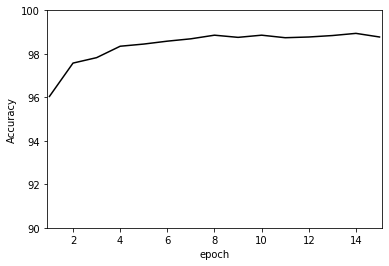

In [9]:
plt.plot(np.arange(1,len(list_accuracy)+1), list_accuracy, 'k')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.axis([0.9,len(list_accuracy)+0.1,90,100]);